In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
!pip install Quandl
!pip install investpy

In [3]:
!pip install missingno

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import quandl
import investpy

# Utils

In [5]:
URL_array  = set()
def link2df(URL,col_name,join_df,join=True,check_column=True,check_URL = True,clear_URL_array=False,show_details=False):
    '''This function scraps the given link and returns dataframe
    __________
    Parameters:
        URL(string): URL to be scrapped from bitcoin website
        col_name(string): column name for dataframe
        join_df(variable)= dataframe withwhich output dataframe will be left joined on Date
        join(boolean)= iF True,join, else don't join
        check_column(boolean)= check if column name already exists
        check_URL(boolean)= check if URL is already processed
        clear_URL_array(boolean)= if true URL_processed array will be cleared
        show_details(boolean)= various details wil be printed such as scrapping first and last details, df head & df tail     
        '''
        
    print(f'processing {col_name}')

    #clear URL append array
    if clear_URL_array==True:
        URL_array.clear()

    #set join parameters if false
    if join == False:
        join_df = None
        check_column=False

    #process column name by making it lowercase and replacing spaces,commas, full stops
    col_name = col_name.lower().replace(',','').replace(" ", "_").replace(".", "_")

    #col_name validation if exists already
    if check_column==True and col_name in list(join_df.columns):
        print(f'column {col_name} already esists in dataframe, stopped here')
        return join_df

    #URL validation if processes already
    elif check_URL==True and URL in list(URL_array):
        print(f'{URL} is already processed, stopped here')
        return join_df 

    #web scrapping
    page = requests.get(URL)
    soup = page.content
    soup = str(soup)
    scraped_output = (soup.split('[[')[1]).split('{labels')[0][0:-2]
    if show_details == True:
        print('head')
        print({scraped_output[0:30]})
        print('tail')
        print({scraped_output[-30:]})

    processed_str = scraped_output.replace('new Date(','')
    processed_str = processed_str.replace(')','')
    processed_str = processed_str.replace('[','')
    processed_str = processed_str.replace(']','')
    processed_str = processed_str.replace('"','')

    processed_str_list = processed_str.split(',')
    date_list,data_list = processed_str_list[::2],processed_str_list[1::2]

    #validate column lengths
    if len(date_list)!=len(data_list):
        print(f'date & data length:{len(date_list),len(data_list),len(date_list)==len(data_list)}')

    #convert list data to a dataframe
    if join == False:
        df = pd.DataFrame()
        df['Date'] = pd.to_datetime(date_list)
        df[col_name] = data_list
        URL_array.add(URL)
        if show_details == True:
            print('*'*100)
            print('df head')
            print(df.head(1))
            print('*'*100)
            print('df tail')
            print(df.tail(1))
            print('*'*100)
            print(f'df shape{df.shape}')
            print('='*100)
            
        return df

    elif col_name not in list(join_df.columns) and join == True:
        df = pd.DataFrame()
        df['Date'] = pd.to_datetime(date_list)
        df[col_name] = data_list
        join_df = pd.merge(join_df,df,on=['Date'],how='left')
        URL_array.add(URL)
        if show_details == True:
            print('*'*100)
            print('df head')
            print(df.head(1))
            print('*'*100)
            print('df tail')
            print(df.tail(1))
            print('*'*100)
            print(f'output df shape= {df.shape},joined_df shape = {join_df.shape}')
            print('='*100)
            print(f'Number of duplicate columns in dataframe {df.columns.duplicated().sum()}')
            print('='*100)
    
        return join_df

# DATA 

In [6]:
bitcoin_prices = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv",
                       parse_dates=["Timestamp"], 
                       index_col=["Timestamp"]) 

In [7]:
bitcoin_prices.index = [datetime.fromtimestamp(x) for x in bitcoin_prices.index]

In [8]:
bitcoin_prices

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
2011-12-31 08:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 08:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 08:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 08:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 08:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-03-31 01:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
2021-03-31 01:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
2021-03-31 01:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
2021-03-31 01:59:00,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


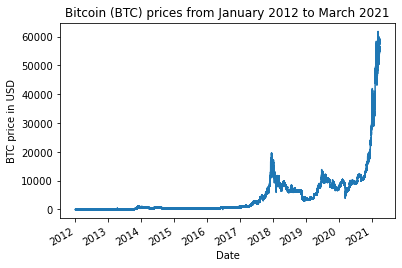

In [9]:
bitcoin_prices["Close"].plot()
plt.title("Bitcoin (BTC) prices from January 2012 to March 2021")
plt.xlabel("Date")
plt.ylabel("BTC price in USD")
plt.show()

In [10]:
bitcoin_prices = bitcoin_prices.iloc[np.logical_and(bitcoin_prices.index >= "2013-04-01",
                                   bitcoin_prices.index <= "2020-04-20")]

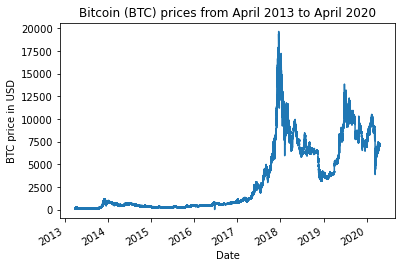

In [11]:
bitcoin_prices["Close"].plot()
plt.title("Bitcoin (BTC) prices from April 2013 to April 2020")
plt.xlabel("Date")
plt.ylabel("BTC price in USD")
plt.show()

# Web scrapping 

### Price

In [12]:
final_df = investpy.get_crypto_historical_data(crypto='bitcoin',from_date='01/04/2013',to_date='19/04/2021')
final_df = final_df.reset_index()
final_df.drop(['Currency','Volume'],inplace=True,axis=1)
final_df.columns = ['Date','opening_price','highest_price','lowest_price','closing_price']
final_df

,Date,opening_price,highest_price,lowest_price,closing_price
0,2013-04-01,93.0,106.0,92.2,104.0
1,2013-04-02,104.0,118.4,99.0,118.0
2,2013-04-03,118.0,147.0,110.0,135.0
3,2013-04-04,135.0,142.1,116.4,132.1
4,2013-04-05,132.1,144.9,130.2,142.3
...,...,...,...,...,...
2936,2021-04-15,62978.6,63729.1,62067.5,63216.0
2937,2021-04-16,63211.6,63518.5,60027.3,61379.7
2938,2021-04-17,61358.3,62509.1,59672.1,60041.9
2939,2021-04-18,60043.2,60362.1,51817.6,56207.1


### Number of transactions in blockchain per day 

In [13]:
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-transactions.html',
                   'transactions in blockchain',join_df=final_df,join=True)

processing transactions in blockchain


### Average block size

In [14]:
final_df = link2df('https://bitinfocharts.com/comparison/size-btc.html',
                   'avg block size',join_df=final_df,join=True)

processing avg block size


### Number of unique (from) adresses per day

In [15]:
final_df = link2df('https://bitinfocharts.com/comparison/sentbyaddress-btc.html',
                   'sent by adress',join_df=final_df,join=True)

processing sent by adress


### Average mining difficulty per day

In [16]:
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-difficulty.html',
                   'avg mining difficulty',join_df=final_df,join=True)

processing avg mining difficulty


### Average hashrate (hash/s) per day

In [17]:
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-hashrate.html',
                   'avg hashrate',join_df=final_df,join=True)

processing avg hashrate


### Mining Profitability USD/Day for 1 Hash/s

In [18]:
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-mining_profitability.html',
                   'mining profitability',join_df=final_df,join=True)

processing mining profitability


### Sent coins in USD per day

In [20]:
final_df = link2df('https://bitinfocharts.com/comparison/sentinusd-btc.html',
                   'Sent coins in USD',join_df=final_df,join=True)

processing Sent coins in USD


### Average transaction fee, USD

In [22]:
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-transactionfees.html',
                   'avg transaction fees',join_df=final_df,join=True)

processing avg transaction fees


### Median transaction fee, USD

In [24]:
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-median_transaction_fee.html',
                   'median transaction fees',join_df=final_df,join=True)

processing median transaction fees


### Average block time (minutes)

In [26]:
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-confirmationtime.html',
                   'avg block time',join_df=final_df,join=True)

processing avg block time


### Avg. Transaction Value, USD

In [28]:
final_df = link2df('https://bitinfocharts.com/comparison/transactionvalue-btc.html',
                   'avg transaction value',join_df=final_df,join=True)

processing avg transaction value


### Median Transaction Value, USD

In [30]:
final_df = link2df('https://bitinfocharts.com/comparison/mediantransactionvalue-btc.html',
                   'median transaction value',join_df=final_df,join=True)

processing median transaction value


### Tweets per day

In [32]:
final_df = link2df('https://bitinfocharts.com/comparison/tweets-btc.html',
                   'tweets',join_df=final_df,join=True)

processing tweets


### Google Trends to "Bitcoin" @ 2012-01-01

In [34]:
final_df = link2df('https://bitinfocharts.com/comparison/google_trends-btc.html',
                   'google trends',join_df=final_df,join=True)

processing google trends


### Number of unique (from or to) addresses per day

In [36]:
final_df = link2df('https://bitinfocharts.com/comparison/activeaddresses-btc.html',
                   'active addresses',join_df=final_df,join=True)

processing active addresses


### Top 100 Richest Addresses to Total coins %

In [38]:
final_df = link2df('https://bitinfocharts.com/comparison/top100cap-btc.html',
                   'top100 to total percentage',join_df=final_df,join=True)

processing top100 to total percentage


### Average Fee Percentage in Total Block Reward

In [40]:
final_df = link2df('https://bitinfocharts.com/comparison/fee_to_reward-btc.html',
                   'avg fee to reward',join_df=final_df,join=True)

processing avg fee to reward


### Total number of bitcoins in circulation

In [42]:
btc_in_circulation_df = quandl.get("BCHAIN/TOTBC",authtoken='9ztFCcK4_e1xGo_gjzK7')
btc_in_circulation_df = btc_in_circulation_df.rename(columns={'Value': 'number_of_coins_in_circulation'})

### Bitcoin Miners Revenue

In [44]:
miners_revenue_df = quandl.get("BCHAIN/MIREV",authtoken='9ztFCcK4_e1xGo_gjzK7')
miners_revenue_df = miners_revenue_df.rename(columns={'Value': 'miner_revenue'})

In [45]:
#Filtering data as we are considering this peiod only
final_df = final_df[(final_df['Date'] >= '2013-01-01')].reset_index(drop=True)

final_df = pd.merge(final_df,btc_in_circulation_df,on=['Date'],how='left')
final_df = pd.merge(final_df,miners_revenue_df,on=['Date'],how='left')
final_df

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,avg_block_time,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward,number_of_coins_in_circulation,miner_revenue
0,2013-04-01,93.0,106.0,92.2,104.0,52572,139256,48809,6695826,65502112131790,...,7.273,2592,64.987,NaN,15.248,75756,19.962,0.867,10975275.00,4.818914e+05
1,2013-04-02,104.0,118.4,99.0,118.0,63095,175443,62276,6695826,61845596902013,...,7.956,4400,94.955,NaN,17.192,91875,20.024,1.338,10988125.00,5.312995e+05
2,2013-04-03,118.0,147.0,110.0,135.0,63766,184209,69174,6695826,60270367548897,...,8.229,4478,102.533,NaN,26.608,107142,19.987,1.596,10986575.00,5.384239e+05
3,2013-04-04,135.0,142.1,116.4,132.1,66738,221568,71753,6695826,55272455140085,...,9.351,4249,123.314,NaN,24.681,108890,19.99,1.948,10995725.00,5.251576e+05
4,2013-04-05,132.1,144.9,130.2,142.3,61215,190067,69310,7005058,51815454745655,...,9.114,4348,125.183,NaN,20.514,100034,19.833,1.432,10999925.00,6.064548e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,2021-04-15,62978.6,63729.1,62067.5,63216.0,359268,892547,554823,23217560568175,1.8167943199849E+20,...,8.372,323211,974.167,110223,164.392,1196069,14.513,12.627,18683856.25,8.017224e+07
2937,2021-04-16,63211.6,63518.5,60027.3,61379.7,219601,879567,420883,23581981443664,1.6736603940491E+20,...,13.981,516536,1462,113640,177.284,830078,14.58,17.903,18684418.75,4.835681e+07
2938,2021-04-17,61358.3,62509.1,59672.1,60041.9,194489,879676,353899,23581981443664,1.2155182861954E+20,...,15.824,359703,1459,100583,147.984,773272,14.574,22.344,18684900.00,4.502809e+07
2939,2021-04-18,60043.2,60362.1,51817.6,56207.1,274611,900314,449307,23581981443664,1.2782218196689E+20,...,11.613,337989,1116,178464,267.181,954286,14.568,21.703,18685731.25,5.772197e+07


# Pre-processing

In [ ]:
# shuffled dataset
data_shuffle = bitcoin_prices.sample(frac = 1)

# split ratio test set
ratio = data_shuffle.size//5  #20%

training_set = data_shuffle[ratio:]
test_set = data_shuffle[:ratio]

In [ ]:
training_set

In [ ]:
data_shuffle[:data_shuffle.size//5]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
prices

In [ ]:
df1 = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv', 
                  delimiter=',',
                  parse_dates=["Timestamp"], 
                  index_col=["Timestamp"]) 

In [ ]:
df1

In [ ]:
!wget https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv

# References 

### Scrapping 
https://github.com/rohansawant7978/bitcoin-price-forecasting